In [51]:
# Import thư viện
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import copy

In [3]:
my_url = "."

In [4]:
# Đọc file data_mau.csv (data đã được merge giữa điểm và kế hoạch giảng dạy) và chuyển mã giảng viên sang số từ 1 đến 10.
df = pd.read_csv(f"{my_url}/data/data_mau.csv", index_col=0, converters={"NhomTo": str, "MaNV": str})
# Danh sách giảng viên
gv_set = set(df["MaNV"])
# Convert từ giảng viên sang dạng số từ 1 đến 10
gv_dict = {nv: ((index - 1) * 9 / len(gv_set) + 1) for index, nv in enumerate(gv_set, start=1)}
df["MaNV"] = df["MaNV"].replace(gv_dict)
df["MaNV"] = df["MaNV"].replace(1.0, -1.0)

# Sắp xếp tăng dần theo năm học, học kỳ
df = df.sort_values(by=["NamHoc", "HocKy"], ascending=[True, True]).reset_index(drop=True)
df

,MaSV,MaMH,NamHoc,HocKy,NhomTo,DiemHP,DatHP,MaNV
0,N14DCAT074,BAS1105,2014,1,07,8.7,1,-1.000000
1,N14DCAT074,BAS1106,2014,1,09,7.6,1,2.360465
2,N14DCAT074,BAS1111,2014,1,05,6.6,1,2.726744
3,N14DCAT074,BAS1201,2014,1,02,7.6,1,2.569767
4,N14DCAT074,BAS1203,2014,1,02,6.5,1,2.883721
...,...,...,...,...,...,...,...,...
32266,N18DCCN010,INT1340,2022,3,01,7.5,1,3.145349
32267,N18DCAT023,INT1306,2022,3,01,10.0,1,7.017442
32268,N14DCCN091,INT1450,2023,1,02,1.5,0,-1.000000
32269,N17DCCN095,INT1479-4,2023,1,01,8.0,1,-1.000000


In [5]:
'''
Hàm lấy dữ liệu cho môn cần dự đoán
Input:  ma_mh   string      Mã môn học cần dự đoán,
        xet_gv  boolean     Có xét yếu tố giảng viên hay không (default là không)
Output: df_mh   dataframe   Dataframe mới đã lọc theo mã môn học và giảng viên
'''
def lay_du_lieu_cho_mon_can_du_doan(ma_mh, xet_gv=False):
    # Lọc ra các record có MaMH = mã môn học cần dự đoán
    df_mh = df.loc[df["MaMH"] == ma_mh]
    # Chỉ giữ lại lần học đầu tiên
    df_mh = df_mh.drop_duplicates(subset=["MaSV", "MaMH"], keep="first")
    # Nếu yếu tố giáo viên được xét tới thì bỏ các record có MaNV = -1
    if xet_gv == True:
        df_mh = df_mh.loc[df_mh["MaNV"] != -1.0]
    return df_mh

In [6]:
''' 
Hàm lấy dữ liệu của môn học trước (trước môn học cần dự đoán)
Input:  ma_mh_truoc         string      Mã môn học trước
        df_mh_can_du_doan   dataframe   Dataframe của môn học cần dự đoán (đã được tính ở hàm trên)
        option              string      Các cách tính điểm với trường hợp sinh viên học lại nhiều lần. 
                                        Default: Cách tính theo lấy mới nhất
                                        Ngoài ra: còn có các option là lớn nhất, và trung bình
'''
def lay_du_lieu_mon_hoc_truoc(ma_mh_truoc, df_mh_du_doan, option='moinhat'):
    # Lọc theo ma_mh_truoc
    df_mh_truoc = df.loc[df["MaMH"] == ma_mh_truoc]
    # Inner join theo MaSV
    df_mh_merged = pd.merge(df_mh_truoc, df_mh_du_doan, how="inner", on=["MaSV"])
    '''
    Lấy những record thoả mãn về mặt thời gian:
        - So sánh về năm học
        - Nếu năm học bằng nhau thì so sánh theo học kỳ
    NamHoc_x là năm học của df_mh_truoc, NamHoc_y là năm học của df_mh_du_doan
    '''
    df_mh_filtered = df_mh_merged.loc[(df_mh_merged["NamHoc_x"] < df_mh_merged["NamHoc_y"]) |
                                          ((df_mh_merged["NamHoc_x"] == df_mh_merged["NamHoc_y"])
                                           & (df_mh_merged["HocKy_x"] < df_mh_merged["HocKy_y"]))]
    # Các option lấy kết quả môn học
    # Lấy kết quả mới nhất
    if option == 'moinhat':
        df_mh_filtered = df_mh_filtered.drop_duplicates(subset=["MaSV"], keep="last")
    # Lấy kết quả lớn nhất
    elif option == 'lonnhat':
        df_mh_filtered = df_mh_filtered.loc[df_mh_filtered.groupby("MaSV")["DiemHP_x"].idxmax()]
    # Lấy kết quả trung bình
    elif option == 'trungbinh':
        df_mh_filtered = df_mh_filtered.groupby("MaSV")["DiemHP_x"].mean().reset_index()
    return df_mh_filtered[["MaSV", "DiemHP_x"]].rename(columns={"DiemHP_x": f"DiemHP_{ma_mh_truoc}"})

In [164]:
def thong_ke(mh_du_doan):
    df_mh = lay_du_lieu_cho_mon_can_du_doan(mh_du_doan)
    print(df_mh['DatHP'].value_counts())

In [165]:
thong_ke("INT1306") # CTDL 
thong_ke("INT1332") # lthdt
thong_ke("INT1434-3") # LTW

DatHP
0    388
1    133
Name: count, dtype: int64
DatHP
1    341
0    170
Name: count, dtype: int64
DatHP
1    399
0     78
Name: count, dtype: int64


In [7]:
'''
Lớp lưu thông tin về:
- data train, validation, test, đã được lọc bớt các feature
- f1 score trên bộ validation
- algorithm: thuật toán (logistic regression, gradient boosting)
'''
class FeatureSelectedInfo:
    def __init__(self,
                X_train, y_train,
                X_val, y_val,
                X_test, y_test,
                X_train_transform,
                X_val_transform,
                X_test_transform,
                option,
                features,
                algorithm,
                f1_score):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_transform = X_train_transform
        self.X_val_transform = X_val_transform
        self.X_test_transform = X_test_transform
        self.option = option
        self.features = features
        self.algorithm = algorithm
        self.f1_score = f1_score

In [8]:
'''
Lớp để lưu thông tin mô hình đã huấn luyện
'''
class Model:
    def __init__(self, model, features, option, f1_score, accuracy):
        self.model = model
        self.features = features
        self.option = option
        self.f1_score = f1_score
        self.accuracy = accuracy

In [10]:
'''
Hàm vừa lưu và vừa show các thông tin về thuật toán, bộ feature, cách tính (option), và f1 score
Input:      mh_du_doan              string                      Mã môn học dự đoán
            list_mh_truoc           string                      Danh sách các môn học trước
            n_features              int                         Số lượng các feature sẽ chọn
Output:     selected_feature_infos  list[FeatureSelectedInfo]   Danh sách các lớp FeatureSelectedInfo
'''
def show_selected_feature_info(mh_du_doan, list_mh_truoc, n_features):
    df_mh_du_doan = lay_du_lieu_cho_mon_can_du_doan(mh_du_doan)
    # list_feature = ["MaNV"] Không sử dụng mã giảng viên vì số lượng record của dữ liệu bị hao hụt khá nhiều - khoảng 100 record
    list_feature = list_mh_truoc
    options = ['lonnhat', 'moinhat', 'trungbinh']
    selected_feature_infos = []
    # Với mỗi option
    for option in options:
        copy_df_mh_du_doan = df_mh_du_doan.copy()

        # if "MaNV" in list_feature:
        #     copy_df_mh_du_doan = copy_df_mh_du_doan[copy_df_mh_du_doan["MaNV"] != -1.0]

        # Lấy danh sách các dataframe chứa dữ liệu của các môn học trước
        list_df_mh_truoc = [lay_du_lieu_mon_hoc_truoc(mh_truoc_do, copy_df_mh_du_doan, option)
                for mh_truoc_do in list_feature if mh_truoc_do != "MaNV"]

        df_filtered = copy_df_mh_du_doan
        # Merge các dataframe để lấy các sinh viên đã học các môn trong danh sách list_mh_truoc
        for current_df in list_df_mh_truoc:
            df_filtered = pd.merge(current_df, df_filtered, on="MaSV")
        # Lọc lấy danh sách các sinh viên từ các dataframe df_filtered
        list_masv = set(df_filtered["MaSV"])

        # Lọc lấy dữ liệu của môn học dự đoán theo các mã sinh viên vừa tìm được
        df_mh_du_doan_theo_ma_sv = copy_df_mh_du_doan.loc[copy_df_mh_du_doan["MaSV"].isin(list_masv)]
        df_du_lieu_diem = df_mh_du_doan_theo_ma_sv
        # Với từng dataframe môn học trước, ta sẽ lấy những record mà MaSV trong danh sách vừa tìm được
        # Sau đó, với từng dataframe đã lọc, ta sẽ tiến hành merge theo MaSV với dữ liệu của môn học dự đoán
        for i in range(len(list_df_mh_truoc)):
            list_df_mh_truoc[i] = list_df_mh_truoc[i].loc[list_df_mh_truoc[i]["MaSV"].isin(list_masv)]
            df_du_lieu_diem = df_du_lieu_diem.merge(list_df_mh_truoc[i], on="MaSV")

        # Chuẩn bị danh sách cột cần lấy từ dataframe df_du_lieu_diem
        list_columns = ["MaSV", mh_du_doan, "DiemHP", "DatHP", "MaNV"]
        list_columns.extend([f"DiemHP_{feature}" for feature in list_feature if feature != "MaNV"])
        # Đổi tên cột MaMH thành mã môn học dữ đoán
        df_du_lieu_diem = df_du_lieu_diem.rename(columns={"MaMH": mh_du_doan})[list_columns]
        # Lúc này ta sẽ chỉ lấy các cột là điểm và mã nhân viên (nếu có) làm bộ data
        list_X_columns = [f"DiemHP_{feature}" if feature != "MaNV" else feature for feature in list_feature]
        if len(df_du_lieu_diem) < 100:
            continue

        X = df_du_lieu_diem[list_X_columns].values.reshape(-1, len(list_X_columns))
        # Lấy đạt hay không đạt
        y = df_du_lieu_diem["DatHP"].values
        # Chia thành train:val:test theo tỷ lệ lần lượt là 80:10:10
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Huấn luyên mô hình GradientBossting
        clf_gb = GradientBoostingClassifier()
        # Huấn luyện mô hình hồi quy
        clf_lr = LogisticRegression()

        sfs_gb = SequentialFeatureSelector(clf_gb,
                                           n_features_to_select=n_features,
                                           scoring="f1_weighted",
                                           cv=10,
                                           n_jobs=-1)
        sfs_lr = SequentialFeatureSelector(clf_lr,
                                           n_features_to_select=n_features,
                                           scoring="f1_weighted",
                                           cv=10,
                                           n_jobs=-1)
        # Ta sẽ cho thuật toán k-fold chạy trên bộ dữ liệu là sự kết hợp giữa data train và val 
        X_fold = np.concatenate([X_train, X_val], axis=0)
        y_fold = np.concatenate([y_train, y_val], axis=0)
        sfs_gb.fit(X_fold, y_fold)
        sfs_lr.fit(X_fold, y_fold)
        
        # Lưu dữ liệu để sử dụng lại
        indices_gb = [i for i, v in enumerate(sfs_gb.get_support()) if v]
        indices_lr = [i for i, v in enumerate(sfs_lr.get_support()) if v]
        
        # Sử dụng dữ liệu với bộ feature đã được chọn
        X_train_transform_gb = sfs_gb.transform(X_train)
        X_val_transform_gb = sfs_gb.transform(X_val)
        X_test_transform_gb = sfs_gb.transform(X_test)
        X_train_transform_lr = sfs_lr.transform(X_train)
        X_val_transform_lr = sfs_lr.transform(X_val)
        X_test_transform_lr = sfs_lr.transform(X_test)

        # Tính f1 score trên bộ val với bộ dữ liệu đã được chọn lọc lại theo bộ feature của thuật toán
        clf_gb.fit(X_train_transform_gb, y_train)
        clf_lr.fit(X_train_transform_lr, y_train)
        y_pred_gb = clf_gb.predict(X_val_transform_gb)
        y_pred_lr = clf_lr.predict(X_val_transform_lr)
        f1_gb = f1_score(y_val, y_pred_gb, average="weighted")
        f1_lr = f1_score(y_val, y_pred_lr, average="weighted")

        select_feature_model_gb = FeatureSelectedInfo(X_train, y_train,
                                                      X_val, y_val,
                                                      X_test, y_test,
                                                      X_train_transform_gb,
                                                      X_val_transform_gb,
                                                      X_test_transform_gb,
                                                      option,
                                                      [list_X_columns[x] for x in indices_gb],
                                                      "gb",
                                                      f1_gb)
        select_feature_model_lr = FeatureSelectedInfo(X_train, y_train,
                                                      X_val, y_val,
                                                      X_test, y_test,
                                                      X_train_transform_lr,
                                                      X_val_transform_lr,
                                                      X_test_transform_lr,
                                                      option,
                                                      [list_X_columns[x] for x in indices_lr],
                                                      "lr",
                                                      f1_lr)
        # Lưu vào selected_feature_infos
        selected_feature_infos.extend([select_feature_model_gb, select_feature_model_lr])
        print("GB:\t", [list_X_columns[x] for x in indices_gb], option, f1_gb)
        print("LR:\t", [list_X_columns[x] for x in indices_lr], option, f1_lr)
    return selected_feature_infos

In [11]:
# Hàm tìm và in ra các giá trị theo số lượng feature
def find_best_feat(min_feat, max_feat, mh_du_doan, mh_qua_khu):
    models = []
    for i in range(min_feat, max_feat + 1):
        models.append(show_selected_feature_info(mh_du_doan, mh_qua_khu, i))
    return models

In [90]:
# Các hyperparameters
param_grid_lr = {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'], 
    'C': [0.01, 0.1, 1]
}
param_grid_gb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 3, 4],
    'max_depth': [4, 5, 6],
}

Môn cấu trúc dữ liệu và giải thuật (THCS2)

In [47]:
# Môn CTDL&GT
models_INT1306 = find_best_feat(2, 3, "INT1306", ["INT1339", "INT1155", "INT1154", "INT1358"])

GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] lonnhat 0.6858974358974359
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] lonnhat 0.6410256410256412
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] moinhat 0.6560264171711613
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] moinhat 0.6410256410256412
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] trungbinh 0.6384479717813052
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] trungbinh 0.6410256410256412
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] lonnhat 0.6560264171711613
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] lonnhat 0.6410256410256412
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] moinhat 0.7018895615483396
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] moinhat 0.6261471861471861
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] trungbinh 0.6858974358974359
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1358'] trungbinh 0.6261471861471861


In [91]:
model_INT1306 = models_INT1306[1][2]
X_train_transform_INT1306 = model_INT1306.X_train_transform
y_train_INT1306 = model_INT1306.y_train
X_test_transform_INT1306 = model_INT1306.X_test_transform
y_test_INT1306 = model_INT1306.y_test
X_val_transform_INT1306 = model_INT1306.X_val_transform
y_val_INT1306 = model_INT1306.y_val
features_INT1306 = model_INT1306.features
option_INT1306 = model_INT1306.option
X_fold_transform_INT1306 = np.concatenate([X_train_transform_INT1306, X_val_transform_INT1306], axis=0)
y_fold_INT1306 = np.concatenate([y_train_INT1306, y_val_INT1306])

In [170]:
features = copy.deepcopy(features_INT1306)
features.append("DatHP")
pd.DataFrame(np.concatenate((X_train_transform_INT1306, 
                             np.reshape(y_train_INT1306, (len(y_train_INT1306), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1306_train.csv")
pd.DataFrame(np.concatenate((X_val_transform_INT1306, 
                             np.reshape(y_val_INT1306, (len(y_val_INT1306), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1306_val.csv")
pd.DataFrame(np.concatenate((X_test_transform_INT1306, 
                             np.reshape(y_test_INT1306, (len(y_test_INT1306), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1306_test.csv")

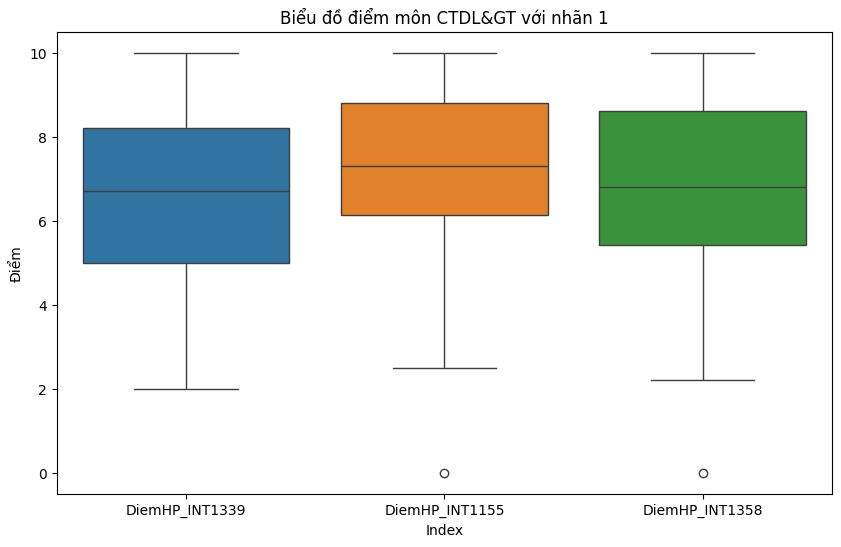

In [93]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1306, columns=model_INT1306.features), 
                         pd.DataFrame(y_train_INT1306, columns=["DatHP"])], axis=1)
df_thong_ke_dat = df_thong_ke[df_thong_ke["DatHP"] == 1].reset_index(drop=True)
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_thong_ke_dat[model_INT1306.features], palette='tab10', marker='o')
sns.boxplot(data=df_thong_ke_dat[model_INT1306.features], palette='tab10')

plt.title('Biểu đồ điểm môn CTDL&GT với nhãn 1')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

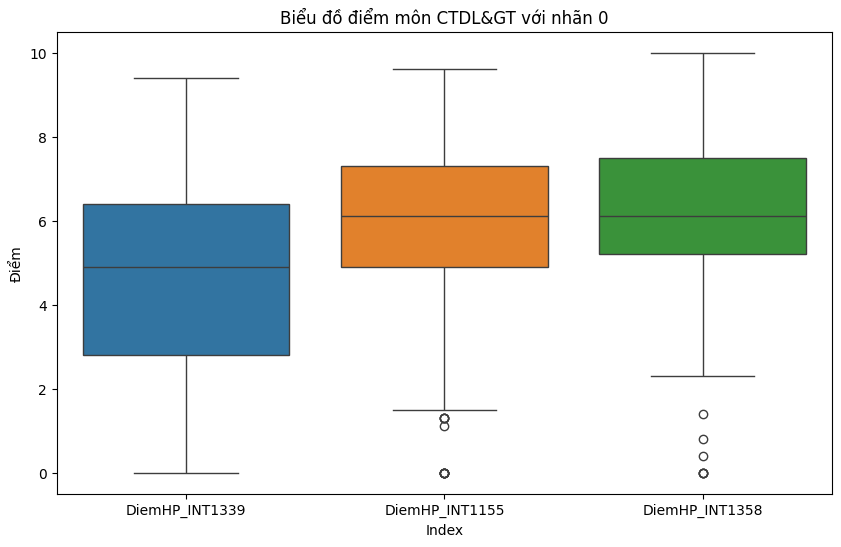

In [94]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1306, columns=model_INT1306.features), 
                         pd.DataFrame(y_train_INT1306, columns=["DatHP"])], axis=1)
df_thong_ke_khong_dat = df_thong_ke[df_thong_ke["DatHP"] == 0].reset_index(drop=True)
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_thong_ke_khong_dat[model_INT1306.features], palette='tab10', marker='o')
sns.boxplot(data=df_thong_ke_khong_dat[model_INT1306.features], palette='tab10')

plt.title('Biểu đồ điểm môn CTDL&GT với nhãn 0')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

In [95]:
# LR
grid_search_lr_INT1306 = GridSearchCV(LogisticRegression(), param_grid_lr, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_lr_INT1306.fit(X_fold_transform_INT1306, y_fold_INT1306)
best_params_lr_INT1306 = grid_search_lr_INT1306.best_params_
# GB
grid_search_gb_INT1306 = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_gb_INT1306.fit(X_fold_transform_INT1306, y_fold_INT1306)
best_params_gb_INT1306 = grid_search_gb_INT1306.best_params_

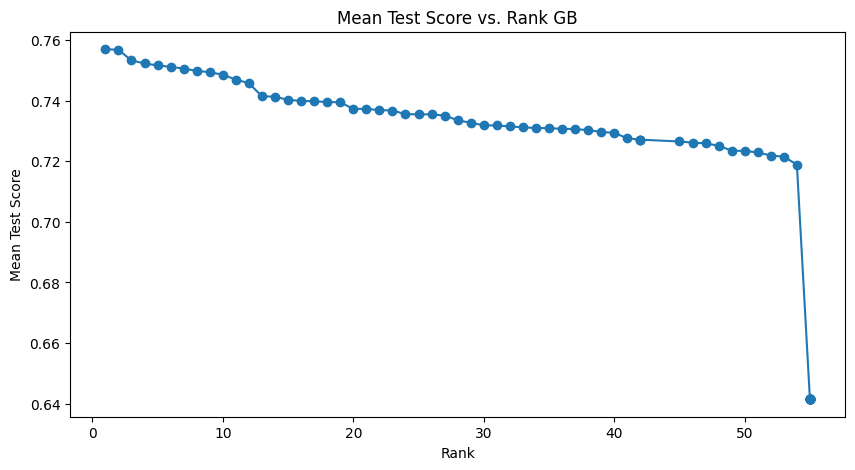

In [96]:
pd_grid_search_gb = pd.DataFrame(grid_search_gb_INT1306.cv_results_)
pd_grid_search_gb = pd_grid_search_gb.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_gb['mean_test_score']
ranks = pd_grid_search_gb['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank GB')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

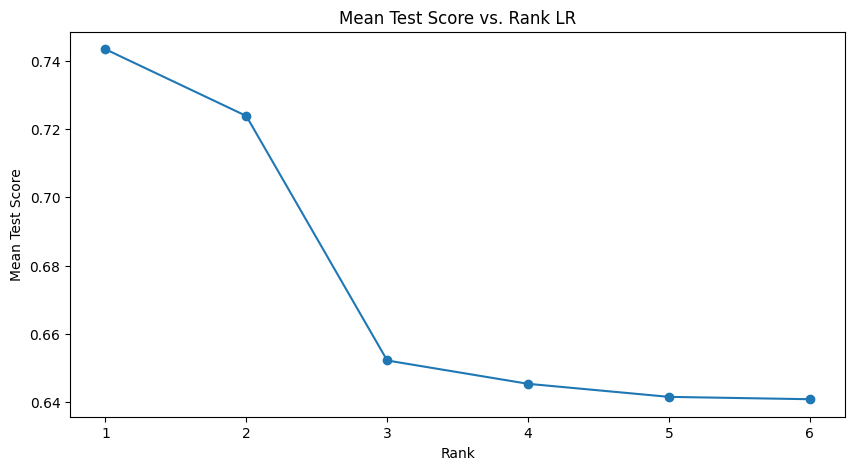

In [97]:
pd_grid_search_lr = pd.DataFrame(grid_search_lr_INT1306.cv_results_)
pd_grid_search_lr = pd_grid_search_lr.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_lr['mean_test_score']
ranks = pd_grid_search_lr['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank LR')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

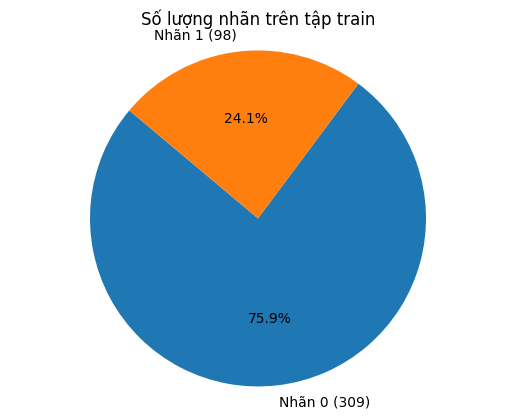

In [98]:
# y_train = best_INT1306.y_train
unique, counts = np.unique(y_train_INT1306, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập train')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

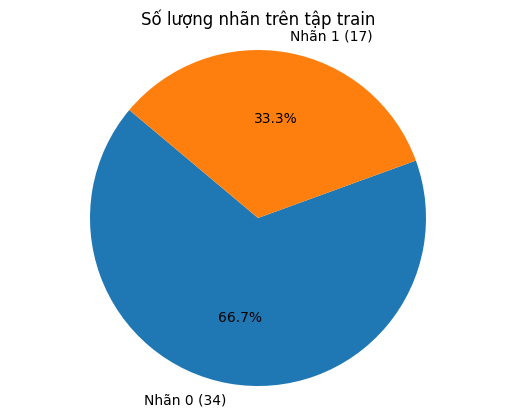

In [99]:
# y_train = best_INT1306.y_train
unique, counts = np.unique(y_test_INT1306, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập train')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

In [100]:
print(best_params_gb_INT1306)
print(best_params_lr_INT1306)

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 300}
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [101]:
gb_model_INT1306 = GradientBoostingClassifier(**best_params_gb_INT1306).fit(X_train_transform_INT1306, y_train_INT1306)
lr_model_INT1306 = LogisticRegression(**best_params_lr_INT1306).fit(X_train_transform_INT1306, y_train_INT1306)
gb_predictions = gb_model_INT1306.predict(X_test_transform_INT1306)
lr_predictions = lr_model_INT1306.predict(X_test_transform_INT1306)
accuracy_gb = accuracy_score(y_test_INT1306, gb_predictions)
accuracy_lr = accuracy_score(y_test_INT1306, lr_predictions)
f1_score_gb = f1_score(y_test_INT1306, gb_predictions, average="weighted")
f1_score_lr = f1_score(y_test_INT1306, lr_predictions, average="weighted")

In [102]:
gb_model_INT1306 = Model(gb_model_INT1306, features_INT1306, option_INT1306, f1_score_gb, accuracy_gb)
lr_model_INT1306 = Model(lr_model_INT1306, features_INT1306, option_INT1306, f1_score_lr, accuracy_lr)

In [103]:
# Save to disk
pickle.dump(gb_model_INT1306, open(f"{my_url}/models/thanh/models_INT1306_gb.sav", "wb"))
pickle.dump(lr_model_INT1306, open(f"{my_url}/models/thanh/models_INT1306_lr.sav", "wb"))

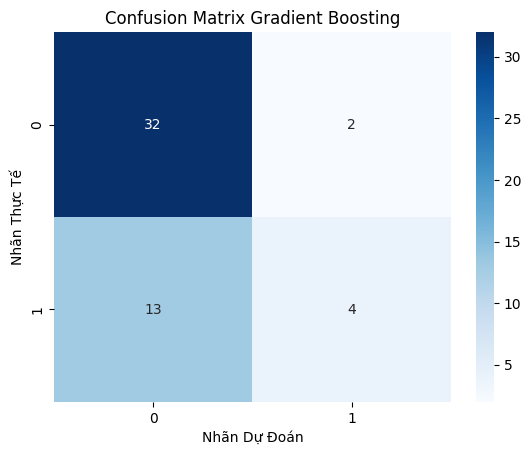

In [69]:
cm_gb = confusion_matrix(y_test_INT1306, gb_predictions)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Gradient Boosting')
plt.show()

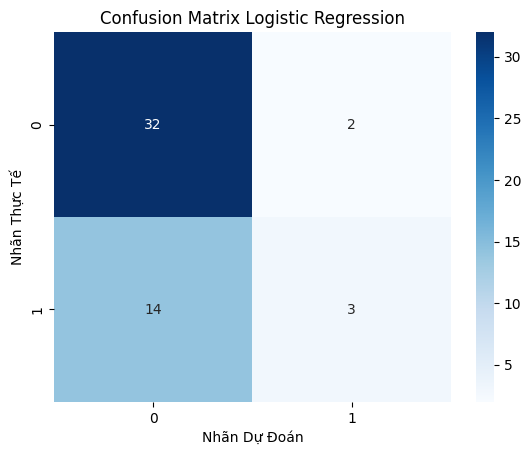

In [70]:
cm_lr = confusion_matrix(y_test_INT1306, lr_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

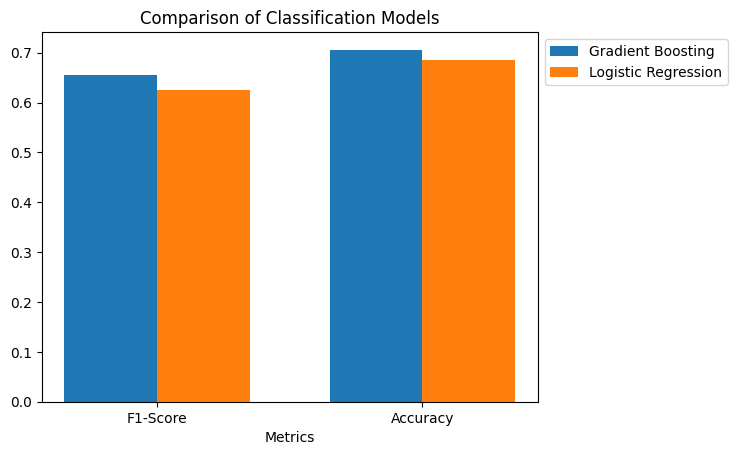

In [71]:
# Tạo các nhãn cho trục x
labels = ['F1-Score', 'Accuracy']

# Tạo các giá trị cho mỗi thuật toán
gbc_values = [f1_score_gb, accuracy_gb]
lr_values = [f1_score_lr, accuracy_lr]

# Định nghĩa vị trí của các cột trên trục x
x = np.arange(len(labels))

# Tạo biểu đồ
fig, ax = plt.subplots()
bar_width = 0.35  # Giảm kích thước cột
ax.bar(x - bar_width/2, gbc_values, width=bar_width, label='Gradient Boosting', align='center')
ax.bar(x + bar_width/2, lr_values, width=bar_width, label='Logistic Regression', align='center')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Di chuyển bảng chú thích ra ngoài biểu đồ
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Hiển thị biểu đồ
plt.show()

Môn lập trình hướng đối tượng (có môn tiên quyết là Lập trình C++)

In [115]:
# Lập trình C++, Cấu trúc dữ liệu và giải thuật, tin học cơ sở 2, tin học cơ sở 1
models_INT1332 = find_best_feat(2, 3, "INT1332", ["INT1339", "INT1306", "INT1155", "INT1154"])

GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] lonnhat 0.6967563837129055
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155'] lonnhat 0.7142857142857142
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] moinhat 0.7142857142857142
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] moinhat 0.7069868051049103
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] trungbinh 0.7520657581656934
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] trungbinh 0.7251336898395723
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306', 'DiemHP_INT1155'] lonnhat 0.7251336898395723
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1155', 'DiemHP_INT1154'] lonnhat 0.6793226381461676
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306', 'DiemHP_INT1155'] moinhat 0.6967563837129055
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1306', 'DiemHP_INT1154'] moinhat 0.6793226381461676
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306', 'DiemHP_INT1155'] trungbinh 0.8167557932263816
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1306', 'DiemHP_INT1154'] trungbinh 0.6619078520441272


In [132]:
model_INT1332 = models_INT1332[0][4]
X_train_transform_INT1332 = model_INT1332.X_train_transform
y_train_INT1332 = model_INT1332.y_train
X_test_transform_INT1332 = model_INT1332.X_test_transform
y_test_INT1332 = model_INT1332.y_test
X_val_transform_INT1332 = model_INT1332.X_val_transform
y_val_INT1332 = model_INT1332.y_val
features_INT1332 = model_INT1332.features
option_INT1332 = model_INT1332.option
X_fold_transform_INT1332 = np.concatenate([X_train_transform_INT1332, X_val_transform_INT1332], axis=0)
y_fold_INT1332 = np.concatenate([y_train_INT1332, y_val_INT1332])

In [166]:
features = copy.deepcopy(features_INT1332)
features.append("DatHP")
pd.DataFrame(np.concatenate((X_train_transform_INT1332, 
                             np.reshape(y_train_INT1332, (len(y_train_INT1332), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1332_train.csv")
pd.DataFrame(np.concatenate((X_val_transform_INT1332, 
                             np.reshape(y_val_INT1332, (len(y_val_INT1332), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1332_val.csv")
pd.DataFrame(np.concatenate((X_test_transform_INT1332, 
                             np.reshape(y_test_INT1332, (len(y_test_INT1332), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1332_test.csv")

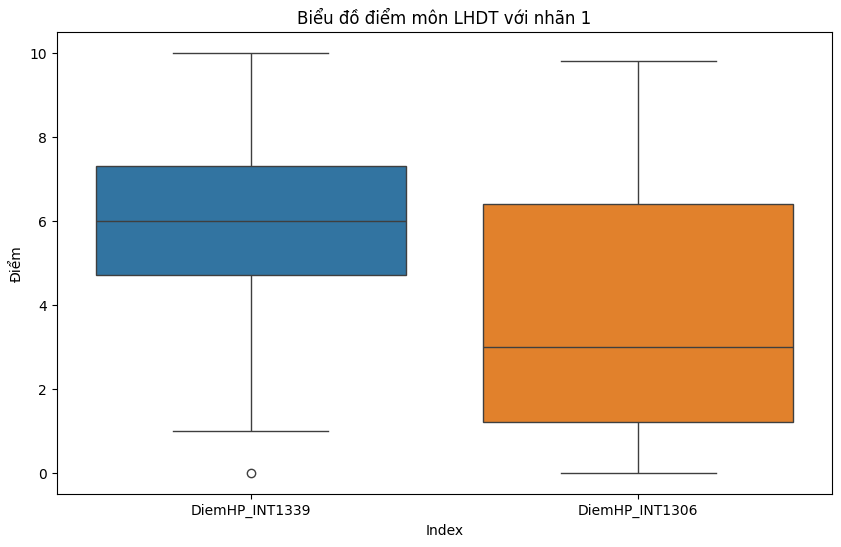

In [133]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1332, columns=model_INT1332.features), 
                         pd.DataFrame(y_train_INT1332, columns=["DatHP"])], axis=1)
df_thong_ke_dat = df_thong_ke[df_thong_ke["DatHP"] == 1].reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_thong_ke_dat[model_INT1332.features], palette='tab10')

plt.title('Biểu đồ điểm môn LHDT với nhãn 1')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

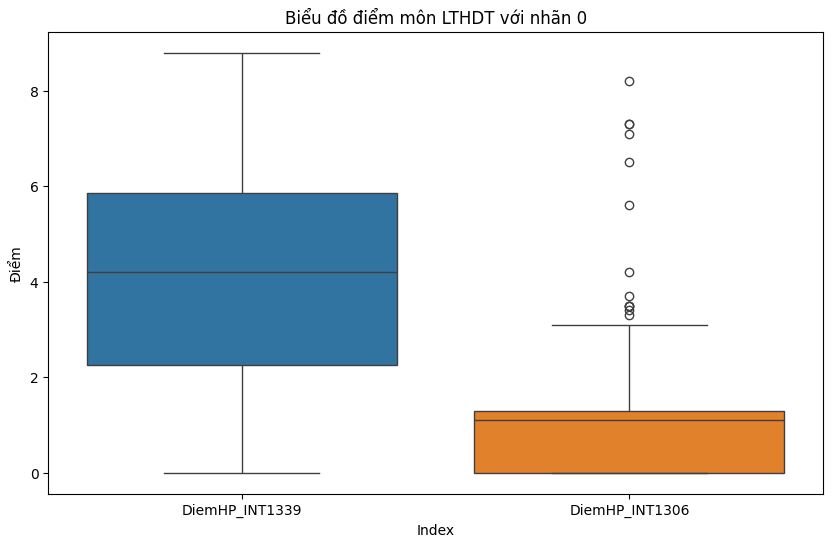

In [134]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1332, columns=model_INT1332.features), 
                         pd.DataFrame(y_train_INT1332, columns=["DatHP"])], axis=1)
df_thong_ke_dat = df_thong_ke[df_thong_ke["DatHP"] == 0].reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_thong_ke_dat[model_INT1332.features], palette='tab10')

plt.title('Biểu đồ điểm môn LTHDT với nhãn 0')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

In [135]:
# LR
grid_search_lr_INT1332 = GridSearchCV(LogisticRegression(), param_grid_lr, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_lr_INT1332.fit(X_fold_transform_INT1332, y_fold_INT1332)
best_params_lr_INT1332 = grid_search_lr_INT1332.best_params_
# GB
grid_search_gb_INT1332 = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_gb_INT1332.fit(X_fold_transform_INT1332, y_fold_INT1332)
best_params_gb_INT1332 = grid_search_gb_INT1332.best_params_

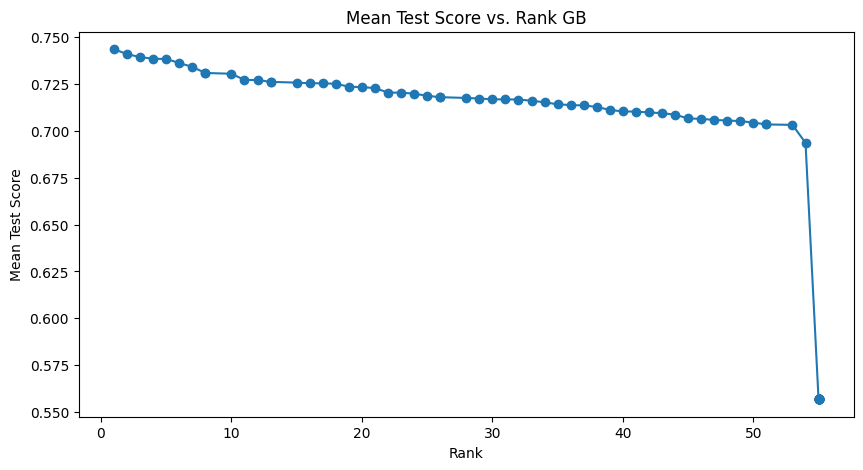

In [136]:
pd_grid_search_gb = pd.DataFrame(grid_search_gb_INT1332.cv_results_)
pd_grid_search_gb = pd_grid_search_gb.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_gb['mean_test_score']
ranks = pd_grid_search_gb['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank GB')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

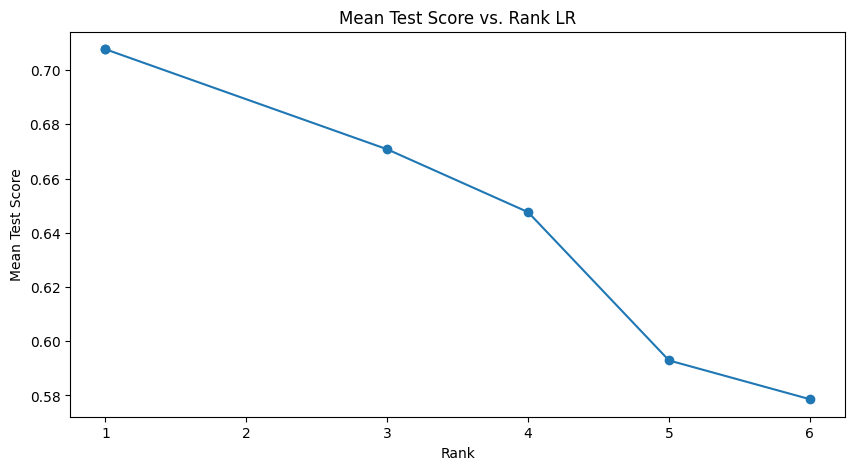

In [137]:
pd_grid_search_lr = pd.DataFrame(grid_search_lr_INT1332.cv_results_)
pd_grid_search_lr = pd_grid_search_lr.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_lr['mean_test_score']
ranks = pd_grid_search_lr['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank LR')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

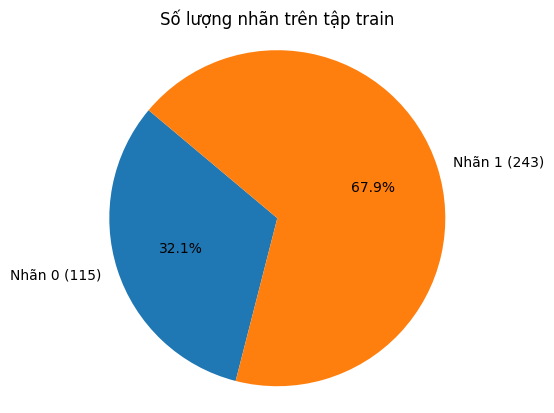

In [138]:
# y_train = best_INT1332.y_train
unique, counts = np.unique(y_train_INT1332, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập train')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

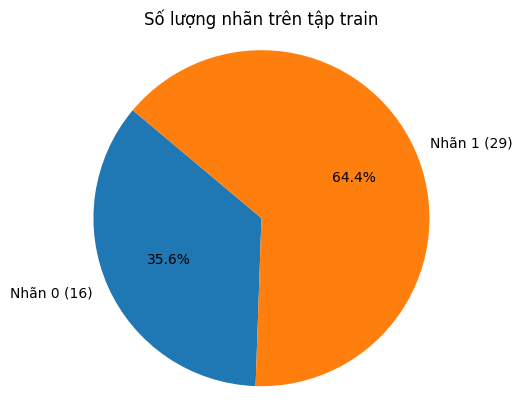

In [139]:
# y_train = best_INT1332.y_test
unique, counts = np.unique(y_test_INT1332, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập test')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

In [140]:
gb_model_INT1332 = GradientBoostingClassifier(**best_params_gb_INT1332).fit(X_train_transform_INT1332, y_train_INT1332)
lr_model_INT1332 = LogisticRegression(**best_params_lr_INT1332).fit(X_train_transform_INT1332, y_train_INT1332)
gb_predictions = gb_model_INT1332.predict(X_test_transform_INT1332)
lr_predictions = lr_model_INT1332.predict(X_test_transform_INT1332)
accuracy_gb = accuracy_score(y_test_INT1332, gb_predictions)
accuracy_lr = accuracy_score(y_test_INT1332, lr_predictions)
f1_score_gb = f1_score(y_test_INT1332, gb_predictions, average="weighted")
f1_score_lr = f1_score(y_test_INT1332, lr_predictions, average="weighted")

In [167]:
print(best_params_gb_INT1332)
print(best_params_lr_INT1332)

{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 100}
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [141]:
gb_model_INT1332 = Model(gb_model_INT1332, features_INT1332, option_INT1332, f1_score_gb, accuracy_gb)
lr_model_INT1332 = Model(lr_model_INT1332, features_INT1332, option_INT1332, f1_score_lr, accuracy_lr)

In [145]:
# Save to disk
pickle.dump(gb_model_INT1332, open(f"{my_url}/models/thanh/models_INT1332_gb.sav", "wb"))
pickle.dump(lr_model_INT1332, open(f"{my_url}/models/thanh/models_INT1332_lr.sav", "wb"))

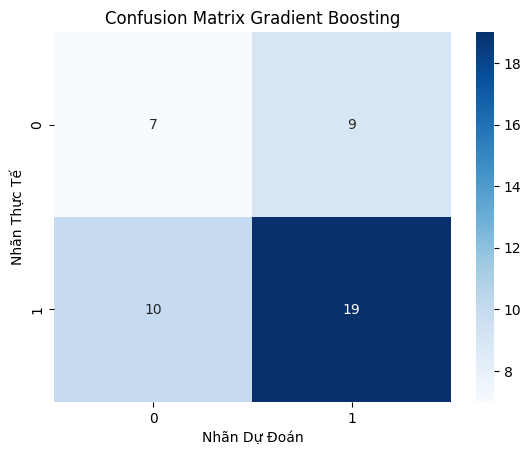

In [142]:
cm_gb = confusion_matrix(y_test_INT1332, gb_predictions)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Gradient Boosting')
plt.show()

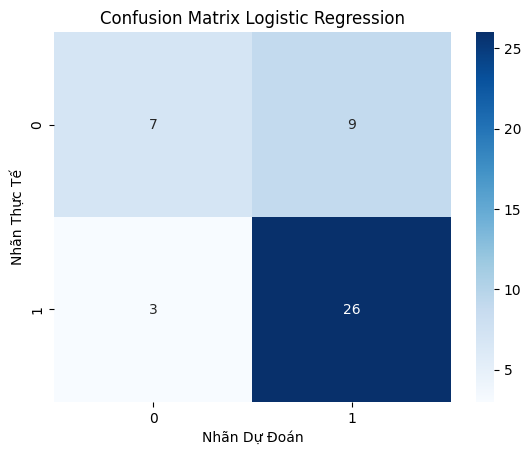

In [143]:
cm_lr = confusion_matrix(y_test_INT1332, lr_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

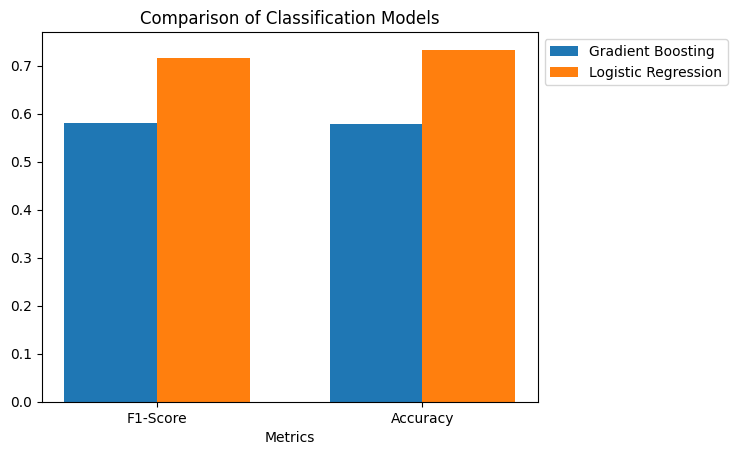

In [144]:
# Tạo các nhãn cho trục x
labels = ['F1-Score', 'Accuracy']

# Tạo các giá trị cho mỗi thuật toán
gbc_values = [f1_score_gb, accuracy_gb]
lr_values = [f1_score_lr, accuracy_lr]

# Định nghĩa vị trí của các cột trên trục x
x = np.arange(len(labels))

# Tạo biểu đồ
fig, ax = plt.subplots()
bar_width = 0.35  # Giảm kích thước cột
ax.bar(x - bar_width/2, gbc_values, width=bar_width, label='Gradient Boosting', align='center')
ax.bar(x + bar_width/2, lr_values, width=bar_width, label='Logistic Regression', align='center')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Di chuyển bảng chú thích ra ngoài biểu đồ
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Hiển thị biểu đồ
plt.show()

Môn lập trình web (Chuyên ngành, Có môn tiên quyết là Lập trình C++)

In [148]:
# C++ (tiên quyết), lập trình hướng đối tượng (C++), csdl, ctdl&gt
models_INT1434_3 = find_best_feat(2, 3, "INT1434-3", ["INT1339", "INT1332", "INT1313", "INT1306"])

GB:	 ['DiemHP_INT1339', 'DiemHP_INT1332'] lonnhat 0.8166666666666667
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332'] lonnhat 0.8166666666666667
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1306'] moinhat 0.8
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332'] moinhat 0.8166666666666667
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1332'] trungbinh 0.8693693693693694
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332'] trungbinh 0.8166666666666667
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1306'] lonnhat 0.8040540540540541
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1313'] lonnhat 0.8693693693693694
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1306'] moinhat 0.8040540540540541
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1313'] moinhat 0.8693693693693694
GB:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1306'] trungbinh 0.8040540540540541
LR:	 ['DiemHP_INT1339', 'DiemHP_INT1332', 'DiemHP_INT1313'] trungbinh 0.8693693693693694


In [149]:
model_INT1434_3 = models_INT1434_3[1][3]
X_train_transform_INT1434_3 = model_INT1434_3.X_train_transform
y_train_INT1434_3 = model_INT1434_3.y_train
X_test_transform_INT1434_3 = model_INT1434_3.X_test_transform
y_test_INT1434_3 = model_INT1434_3.y_test
X_val_transform_INT1434_3 = model_INT1434_3.X_val_transform
y_val_INT1434_3 = model_INT1434_3.y_val
features_INT1434_3 = model_INT1434_3.features
option_INT1434_3 = model_INT1434_3.option
X_fold_transform_INT1434_3 = np.concatenate([X_train_transform_INT1434_3, X_val_transform_INT1434_3], axis=0)
y_fold_INT1434_3 = np.concatenate([y_train_INT1434_3, y_val_INT1434_3])

In [168]:
features = copy.deepcopy(features_INT1434_3)
features.append("DatHP")
pd.DataFrame(np.concatenate((X_train_transform_INT1434_3, 
                             np.reshape(y_train_INT1434_3, (len(y_train_INT1434_3), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1434_3_train.csv")
pd.DataFrame(np.concatenate((X_val_transform_INT1434_3, 
                             np.reshape(y_val_INT1434_3, (len(y_val_INT1434_3), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1434_3_val.csv")
pd.DataFrame(np.concatenate((X_test_transform_INT1434_3, 
                             np.reshape(y_test_INT1434_3, (len(y_test_INT1434_3), 1))), 
                             axis=1), 
                             columns=features).to_csv("./data/thanh/INT1434_3_test.csv")

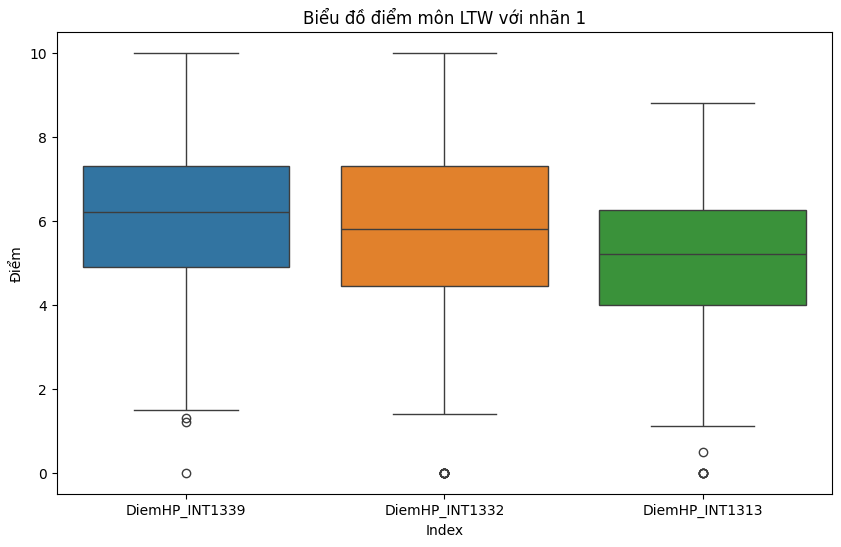

In [171]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1434_3, columns=model_INT1434_3.features), 
                         pd.DataFrame(y_train_INT1434_3, columns=["DatHP"])], axis=1)
df_thong_ke_dat = df_thong_ke[df_thong_ke["DatHP"] == 1].reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_thong_ke_dat[model_INT1434_3.features], palette='tab10')

plt.title('Biểu đồ điểm môn LTW với nhãn 1')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

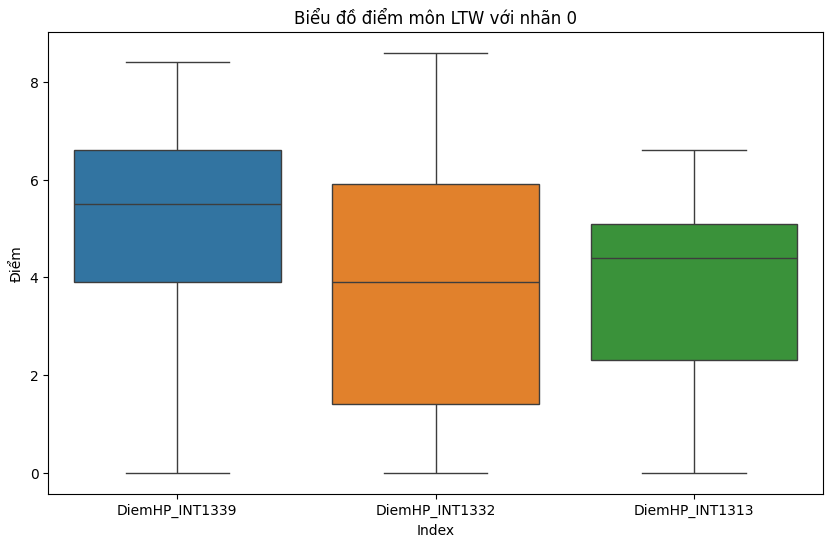

In [172]:
# Thống kê range điểm
df_thong_ke = pd.concat([pd.DataFrame(X_train_transform_INT1434_3, columns=model_INT1434_3.features), 
                         pd.DataFrame(y_train_INT1434_3, columns=["DatHP"])], axis=1)
df_thong_ke_dat = df_thong_ke[df_thong_ke["DatHP"] == 0].reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_thong_ke_dat[model_INT1434_3.features], palette='tab10')

plt.title('Biểu đồ điểm môn LTW với nhãn 0')
plt.xlabel('Index')
plt.ylabel('Điểm')
plt.show()

In [152]:
# LR
grid_search_lr_INT1434_3 = GridSearchCV(LogisticRegression(), param_grid_lr, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_lr_INT1434_3.fit(X_fold_transform_INT1434_3, y_fold_INT1434_3)
best_params_lr_INT1434_3 = grid_search_lr_INT1434_3.best_params_
# GB
grid_search_gb_INT1434_3 = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring="f1_weighted", n_jobs=-1, cv=10)
grid_search_gb_INT1434_3.fit(X_fold_transform_INT1434_3, y_fold_INT1434_3)
best_params_gb_INT1434_3 = grid_search_gb_INT1434_3.best_params_

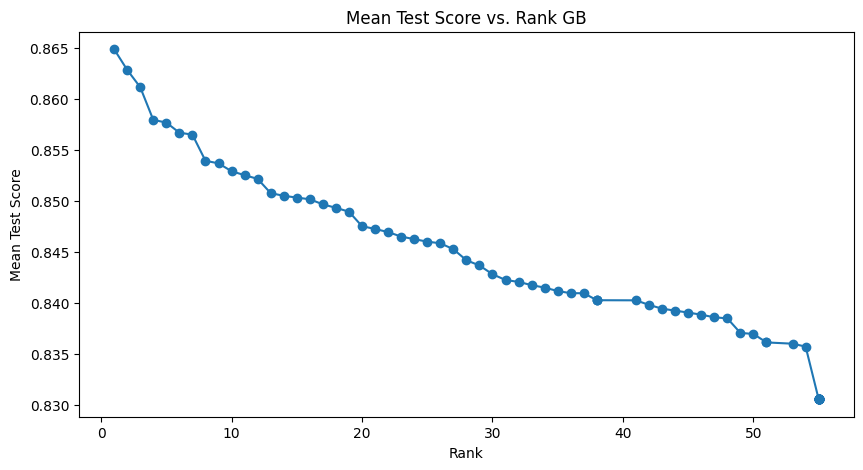

In [153]:
pd_grid_search_gb = pd.DataFrame(grid_search_gb_INT1434_3.cv_results_)
pd_grid_search_gb = pd_grid_search_gb.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_gb['mean_test_score']
ranks = pd_grid_search_gb['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank GB')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

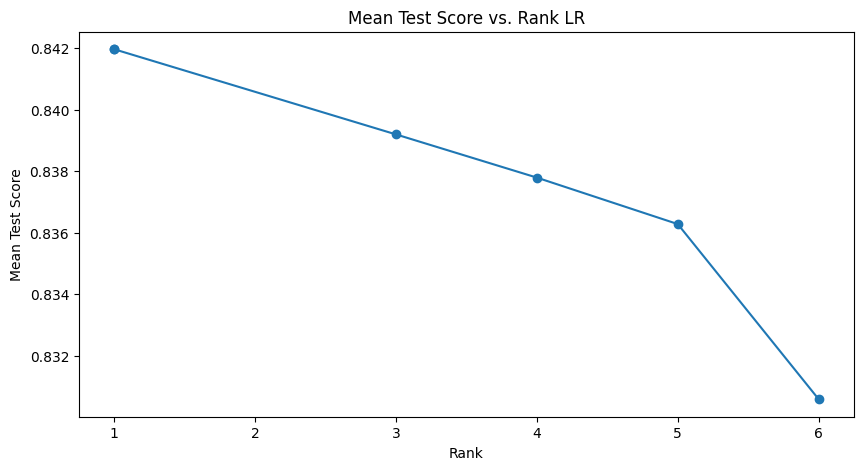

In [154]:
pd_grid_search_lr = pd.DataFrame(grid_search_lr_INT1434_3.cv_results_)
pd_grid_search_lr = pd_grid_search_lr.sort_values('rank_test_score', ascending=True)
mean_test_scores = pd_grid_search_lr['mean_test_score']
ranks = pd_grid_search_lr['rank_test_score']

# Vẽ line chart
plt.figure(figsize=(10, 5))
plt.plot(ranks, mean_test_scores, marker='o')
plt.title('Mean Test Score vs. Rank LR')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score')
# plt.gca().invert_xaxis()  # Đảo ngược trục x để rank cao nhất hiển thị đầu tiên
plt.show()

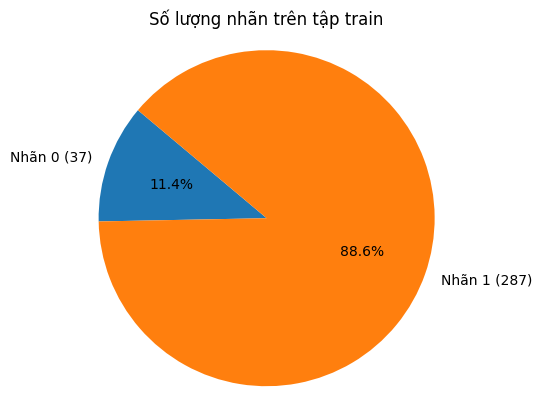

In [155]:
# y_train = best_INT1434_3.y_train
unique, counts = np.unique(y_train_INT1434_3, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập train')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

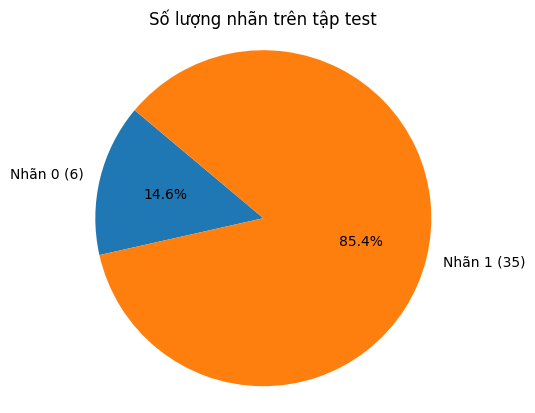

In [156]:
# y_train = best_INT1434_3.y_test
unique, counts = np.unique(y_test_INT1434_3, return_counts=True)

# Tạo nhãn mới bao gồm cả tên nhãn và số lượng
labels_with_counts = [f'Nhãn {label} ({count})' for label, count in zip(unique, counts)]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Số lượng nhãn trên tập test')
plt.axis('equal')  # Đảm bảo biểu đồ tròn được vẽ đúng hình tròn
plt.show()

In [157]:
gb_model_INT1434_3 = GradientBoostingClassifier(**best_params_gb_INT1434_3).fit(X_train_transform_INT1434_3, y_train_INT1434_3)
lr_model_INT1434_3 = LogisticRegression(**best_params_lr_INT1434_3).fit(X_train_transform_INT1434_3, y_train_INT1434_3)
gb_predictions = gb_model_INT1434_3.predict(X_test_transform_INT1434_3)
lr_predictions = lr_model_INT1434_3.predict(X_test_transform_INT1434_3)
accuracy_gb = accuracy_score(y_test_INT1434_3, gb_predictions)
accuracy_lr = accuracy_score(y_test_INT1434_3, lr_predictions)
f1_score_gb = f1_score(y_test_INT1434_3, gb_predictions, average="weighted")
f1_score_lr = f1_score(y_test_INT1434_3, lr_predictions, average="weighted")

In [169]:
print(best_params_gb_INT1434_3)
print(best_params_lr_INT1434_3)

{'learning_rate': 0.01, 'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 300}
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [158]:
gb_model_INT1434_3 = Model(gb_model_INT1434_3, features_INT1434_3, option_INT1434_3, f1_score_gb, accuracy_gb)
lr_model_INT1434_3 = Model(lr_model_INT1434_3, features_INT1434_3, option_INT1434_3, f1_score_lr, accuracy_lr)

In [162]:
# Save to disk
pickle.dump(gb_model_INT1434_3, open(f"{my_url}/models/thanh/models_INT1434_3_gb.sav", "wb"))
pickle.dump(lr_model_INT1434_3, open(f"{my_url}/models/thanh/models_INT1434_3_lr.sav", "wb"))

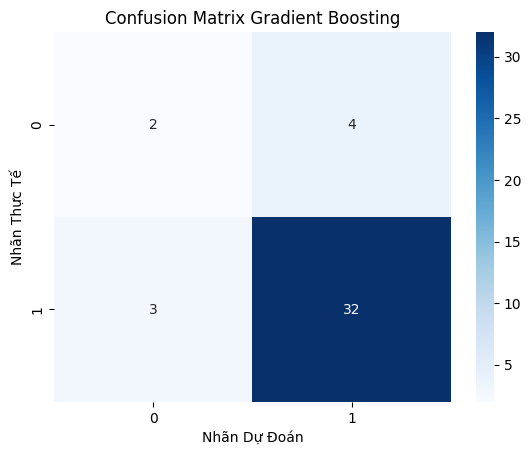

In [159]:
cm_gb = confusion_matrix(y_test_INT1434_3, gb_predictions)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Gradient Boosting')
plt.show()

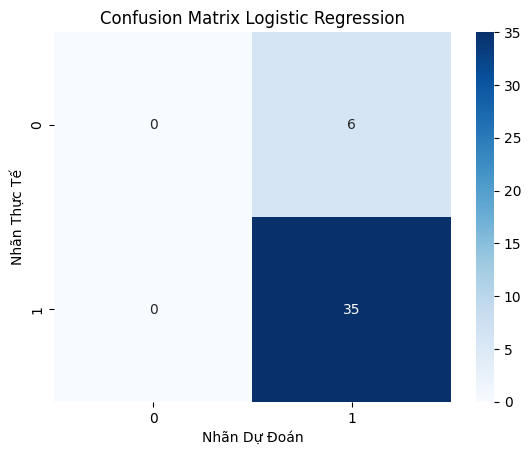

In [160]:
cm_lr = confusion_matrix(y_test_INT1434_3, lr_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

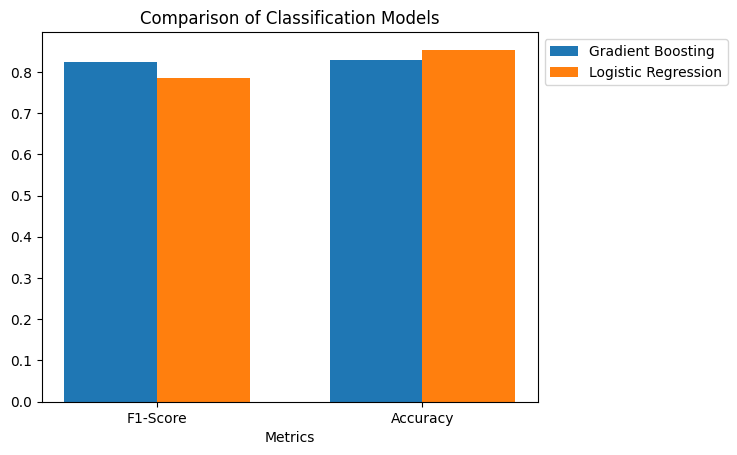

In [161]:
# Tạo các nhãn cho trục x
labels = ['F1-Score', 'Accuracy']

# Tạo các giá trị cho mỗi thuật toán
gbc_values = [f1_score_gb, accuracy_gb]
lr_values = [f1_score_lr, accuracy_lr]

# Định nghĩa vị trí của các cột trên trục x
x = np.arange(len(labels))

# Tạo biểu đồ
fig, ax = plt.subplots()
bar_width = 0.35  # Giảm kích thước cột
ax.bar(x - bar_width/2, gbc_values, width=bar_width, label='Gradient Boosting', align='center')
ax.bar(x + bar_width/2, lr_values, width=bar_width, label='Logistic Regression', align='center')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Di chuyển bảng chú thích ra ngoài biểu đồ
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Hiển thị biểu đồ
plt.show()

In [6]:
load_models_INT1306 = pickle.load(open(f"{my_url}/models/models_INT1306.sav", "rb"), encoding='latin1')